In [164]:
cols = ['name','launch_speed','launch_angle','batter', 'events', 'hc_x','hc_y','relative_spray','description']
scaling_cols = ['launch_speed','launch_angle']
spray_cols = ['launch_speed','launch_angle', 'relative_spray']
desc_cols = ['cluster','launch_angle','launch_speed']

def statcast_spray(statcast_df):
    # Returns the spray_angle which is calculated from the x and y hitting coordinate features in statcast_df
    
    statcast_df['spray_angle'] = np.arctan((statcast_df['hc_x']-125.42)/(198.27-statcast_df['hc_y']))*(180/math.pi)
    statcast_df['relative_spray'] = np.where(
        statcast_df['stand']=='L',
        statcast_df['spray_angle']*-1,
        statcast_df['spray_angle']
    )
    return statcast_df

def statcast_hit_in_play(df):
    # Returns a filtered version of a Statcast DataFrame with only batted balls
    return df[(df['description'] == 'hit_into_play')|
        (df['description'] == 'hit_into_play_no_out') |
        (df['description'] == 'hit_into_play_score')
        ]

def statcast_scale_bbes(bbes):
    # StandardScaler() scaling
    # input: bbes - a DataFrame with Statcast data, for our purposes those will be bbes
    # output: returns the scaled bbes array.
    df = bbes[scaling_cols].dropna(inplace=False)
    scaler = StandardScaler()
    return scaler.fit_transform(df)

def elbow_plot(scaled_df,k_range, n_init=10,title='Elbow Plot'):
    # Creates simple elbow plot for a range of k-values for KMeans
    # Allows custom title and n_init
    inertias = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE,n_init=n_init)
        kmeans.fit(scaled_df)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10,6))
    plt.plot(k_range,inertias,marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title(title)
    plt.show

def silhouette_scores(scaled_df,k_range):
    # Return Silhouette scores for range of k-values
    output = {}

    for k in k_range:
        km = KMeans(n_clusters=k, n_init = 10, random_state=RANDOM_STATE).fit(scaled_df)
        output[str(k)] = silhouette_score(scaled_df,km.labels_)

    return output

def silhouette_and_elbow(scaled_df, k_range):
    # Returns a graph and dictionary of the silhouette scores. More efficient to do together.
    silhouettes = {}
    inertias = []

    for k in k_range:
        km = KMeans(n_clusters=k, n_init = 10, random_state=RANDOM_STATE).fit(scaled_df)
        silhouettes[str(k)] = silhouette_score(scaled_df,km.labels_)
        inertias.append(km.inertia_)
    plt.figure(figsize=(10,6))
    plt.plot(k_range,inertias,marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot')
    plt.show
    
    print(silhouettes)
    
    return silhouettes

def extract_batter_names(df):
    # Extracts the first two words of the description field, format of that field puts 
    # is a string that starts with the name of the batter and what occured
    # i.e., "Vladimir Guerrero hits a home run 450 feet" 
#    cleaned_des = df['des'].str.replace(r'^(Umpire reviewed|Play reviewed).*?:\s*', '', regex=True, case=False)
    df['name'] = df['des'].str.split().str[0:2].str.join(' ')
    return df

def pick_highest_EV_cluster(bbes):
    # Helper function which returns the index of the cluster of a bbe DataFrame
    # with the greatest launch_speed value. This is to identify the line-drive 
    # cluster of balls.
    
    summary = bbes[desc_cols].groupby('cluster').mean()
    return summary['launch_speed'].idxmax()

def get_stinger_clusters(line_drives):
    # Returns integers corresponding to the index of clusters of a cluster-labelled
    # line drives DataFrame. Clusters contain potential stingers.
    
    summary = line_drives[desc_cols].groupby('cluster').mean()
    
    barrels = [summary['launch_angle'].idxmax()]
    non_barrels = summary.iloc[~summary.index.isin(barrels)]
    
    stinger1 = [non_barrels['launch_angle'].idxmax()]
    temp = non_barrels.iloc[~non_barrels.index.isin(stinger1)]
    stinger2 = [temp['launch_angle'].idxmax()]
    
    return stinger1[0], stinger2[0]

def filter_stingers(pot_stingers):
    # Filters out stingers (well-hit line drives) from a potential gappers (and stingers) dataframe
    
    stingers = pot_stingers[((pot_stingers['launch_angle'] <= 18) & (pot_stingers['launch_angle'] >= 5) & (pot_stingers['launch_speed'] >= 95))|
        ((pot_stingers['launch_angle'] <= 20) & (pot_stingers['launch_angle'] >= 10) & (pot_stingers['launch_speed'] >= 90))|
        ((pot_stingers['launch_angle'] <= 20) & (pot_stingers['launch_angle'] >= 12.5) & (pot_stingers['launch_speed'] >=85))|
        ((pot_stingers['launch_angle'] <= 20) & (pot_stingers['launch_angle'] >= 15) & (pot_stingers['launch_speed'] >=80))
        ]
    return stingers


def filter_gappers(stingers):
    # Filters gappers from stingers.
    gappers = stingers[((stingers['relative_spray'].abs() <= 25) & (stingers['relative_spray'].abs() >= 10)) |
                        ((stingers['relative_spray'].abs() >= 37.5) & (stingers['relative_spray'].abs() <= 45))
                        ]
    return gappers

def add_stinger_gapper_label(data):
    # adds labels to the 
    data['stinger'] = 0
    data['gapper'] = 0

    conditions_stinger = [((data['launch_angle'] <= 18) & (data['launch_angle'] >= 5) & (data['launch_speed'] >= 95)).fillna(False).astype(bool),
        ((data['launch_angle'] <= 20) & (data['launch_angle'] >= 10) & (data['launch_speed'] >= 90)).fillna(False).astype(bool),
        ((data['launch_angle'] <= 20) & (data['launch_angle'] >= 12.5) & (data['launch_speed'] >=85)).fillna(False).astype(bool),
        ((data['launch_angle'] <= 20) & (data['launch_angle'] >= 15) & (data['launch_speed'] >=80)).fillna(False).astype(bool)
                 ]

    data['stinger'] = np.select(conditions_stinger, [1,1,1,1])

    columns = data.columns
    if 'relative_spray' not in columns:
        data = statcast_spray(data)
        
    conditions_gapper = [((data['relative_spray'].abs() <= 25) & (data['relative_spray'].abs() >= 10) & (data['stinger'] == 1)).fillna(False).astype(bool),
                        ((data['relative_spray'].abs() >= 37.5) & (data['relative_spray'].abs() <= 45) & (data['stinger'] == 1)).fillna(False).astype(bool)
                        ]

    data['gapper'] = np.select(conditions_gapper, [1,1])
    return data

def get_counts(data):
    counts = {'singles': len(data[data['events']=='single']),
              'doubles': len(data[data['events']=='double']),
              'triples': len(data[data['events']=='triple']),
              'home runs': len(data[data['events']=='home_run']),
              'field outs': len(data[data['events']=='field_out']),
              'gidps': len(data[data['events'] == 'grounded_into_double_play']),
              'force_outs': len(data[data['events']=='force_out']),
              'dps': len(data[data['events']=='double_play']),
              'fcs': (len(data[data['events']=='fielders_choice'])+len(data[data['events']=='fielders_choice_out'])),
              'k': len(data[data['events']=='strikeout']),
              'bb': len(data[data['events'] == 'walk']),
              'ibb': len(data[data['events'] == 'intent_walk']),
              'hbp': len(data[data['events'] == 'hit_by_pitch']),
              'e': len(data[data['events'] == 'error']),
             }
    
    return counts

def create_stats(counts):
    atbats = sum(counts.values)

    stats = {'BA': (counts['singles']+counts['doubles']+counts['triples']+counts['home runs'])/atbats,
            'SLG': (counts['singles']+2*counts['doubles']+3*counts['triples']+4*counts['home runs'])/atbats
             
            }
    return stats

def get_stingers(data):
    # Main function, takes in Statcast data and returns filtered DataFrames with 
    # stingers and gappers. 
    
    # statcast_spray and extract_batter helper functions create attributes 'name',
    # 'spray_angle' and 'relative_spray'
    data = statcast_spray(data)
    data = extract_batter_names(data)
    df = data[cols]

    # helper functions filter the statcast data by whether or not the record represented
    # a batted-ball-event, and create a scaled version for clustering
    bbes = statcast_hit_in_play(df).dropna(inplace=False)
    bbes_scaled = statcast_scale_bbes(bbes[scaling_cols])

    # creates a k-means model with 3 clusters, then use fit_predict to get 
    # cluster labels and create 'cluster' attribute
    km = KMeans(n_clusters=3,n_init=10,random_state=RANDOM_STATE)
    bbes['cluster'] = km.fit_predict(bbes_scaled)
    
    # get integer corresponding to the cluster with the highest launch_speed (EV)
    cluster_idx = pick_highest_EV_cluster(bbes)

    # use the cluster index to filter all batted-ball-events to just line-drives
    line_drives = bbes[(bbes['cluster']==cluster_idx)].drop('cluster',axis=1,inplace=False)
    line_drives_scaled = statcast_scale_bbes(line_drives[scaling_cols])
    
    # create a 4 cluster kmeans model to get cluster labels for the line-drive clusters
    km_drives = KMeans(n_clusters=4,n_init=10,random_state=RANDOM_STATE)
    line_drives['cluster'] = km_drives.fit_predict(line_drives_scaled)

    # helper function returns integers corresponding to the cluster labels of the 
    # potential stinger clusters (high EV, mid-positive LA)
    stinger1, stinger2 = get_stinger_clusters(line_drives)
    pot_stingers = line_drives[(line_drives['cluster'] == stinger1) | (line_drives['cluster'] == stinger2)]

    # helper functions to filter potential stingers to stingers, and stingers to gappers
    stingers = filter_stingers(pot_stingers)
    gappers = filter_gappers(stingers)
    return (stingers, gappers)

def graph_gappers_stingers(gappers, stingers):
    plt.scatter(stingers['hc_x'], stingers['hc_y'],
            color = 'lightgrey', s = 10, alpha = 0.3)
    sns.scatterplot(data = gappers,
                    x = 'hc_x',
                    y = 'hc_y',
                    s = 20,
                    alpha = 0.8
                   )
    return

def add_barrel_label(data):
    ev = data['launch_speed']
    la = data['launch_angle']

    is_barrel = (
        (ev >= 98) &
        (la >= (26 - (ev - 98))) & 
        (la <= (30 + (ev-98)))
    ).fillna(False)

    is_barrel_max = ((ev >= 116) & (la.between(8,50))).fillna(False)

    data['barrel'] = (is_barrel | is_barrel_max).astype(int)
    return data

def add_ss_label(data):
    la = data['launch_angle']

    is_ss = (
        (la >= 8) &
        (la <= 32)
    ).fillna(False)

    data['sweet_spot'] = (is_ss).astype(int)
    return data

def add_walk_label(data):
    events = data['events']

    is_bb = (
        (events == 'walk')
    ).fillna(False)
    data['bb'] = (is_bb).astype(int)
    return data

def add_ibb_label(data):
    events = data['events']

    is_ibb = (
        (events == 'intent_walk')
    ).fillna(False)
    data['ibb'] = (is_ibb).astype(int)
    return data


def add_error_label(data):
    events = data['events']

    is_e = (
        (events == 'error')
    ).fillna(False)
    data['e'] = (is_e).astype(int)
    return data

def add_hbp_label(data): 
    events = data['events']
    is_hbp = (
        (events == 'hit_by_pitch')
    ).fillna(False)
    data['hbp'] = (is_hbp).astype(int)
    return data

def add_pull_label(data):
    spray = data['relative_spray']

    is_pull = (
        (spray <= -15)
    ).fillna(False)
    data['pulled'] = (is_pull).astype(int)
    return data

def add_bbe_label(data):
    events = data['description']

    is_bbe = (
        (events == 'hit_into_play') |
        (events == 'hit_into_play_no_out') |
        (events == 'hit_into_play_score')
    ).fillna(False)
    data['bbe'] = (is_bbe).astype(int)
    return data

def add_hard_hit_label(data):
    events = data['launch_speed'].fillna(0)

    is_hh = (
        (events >= 95)
    ).fillna(False)
    data['hard_hit'] = (is_hh).astype(int)
    return data
    
def add_single_label(data):
    events = data['events']
    is_single = (
        (events == 'single')
    ).fillna(False)
    data['single'] = (is_single).astype(int)
    return data

def add_double_label(data):
    events = data['events']
    is_double = (
        (events == 'double')
    ).fillna(False)
    data['double'] = (is_double).astype(int)
    return data

def add_triple_label(data):
    events = data['events']
    is_triple = (
        (events == 'triple')
    ).fillna(False)
    data['triple'] = (is_triple).astype(int)
    return data

def add_home_run_label(data):
    events = data['events']
    is_homer = (
        (events == 'home_run')
    ).fillna(False)
    data['home_run'] = (is_homer).astype(int)
    return data

def add_outs_label(data):
    events = data['events']
    is_out = (
        (events == 'field_out') |
        (events == 'ground_into_double_play') | 
        (events == 'double_play') | 
        (events == 'triple_play') |
        (events == 'force_out') |
        (events == 'fielders_choice') | 
        (events == 'fielders_choice_out') | 
        (events == 'field_error') |
        (events == 'sac_fly_double_play') |
        (events == 'strikeout_double_play')
    ).fillna(False)
    data['out'] = (is_out).astype(int)
    return data

def add_sac_label(data):
    events = data['events']
    is_sac = (
        (events == 'sac_fly') | 
        (events == 'sac_bunt')
    ).fillna(False)
    data['sac'] = (is_sac).astype(int)
    return data

def add_k_label(data):
    events = data['events']
    is_k = (
        (events == 'strikeout')
    ).fillna(False)
    data['k'] = (is_k).astype(int)
    return data

def add_cint_label(data):
    events = data['events']
    is_k = (
        (events == 'catcher_interf')
    ).fillna(False)
    data['cint'] = (is_k).astype(int)
    return data

def add_non_bbe_labels(data):
    data = add_k_label(data)
    data = add_walk_label(data)
    data = add_hbp_label(data)
    data = add_ibb_label(data)
    data = add_cint_label(data)
    return data

def add_bbe_labels(data):
    data = add_outs_label(data)
    data = add_home_run_label(data)
    data = add_single_label(data)
    data = add_double_label(data)
    data = add_triple_label(data)
    data = add_stinger_gapper_label(data) 
    data = add_barrel_label(data)
    data = add_ss_label(data)
    data = add_pull_label(data)
    data = add_bbe_label(data)
    data = add_hard_hit_label(data)
    data = add_error_label(data)
    data = add_sac_label(data)
    

    return data

def add_avg_slg(data):
    singles = data['singles']
    doubles = data['doubles']
    triples = data['triples']
    homeruns = data['home_runs']
    at_bats = data['at_bats']

    data ['SLG'] = (singles + 2*doubles + 3*triples + 4*homeruns)/at_bats
    data['AVG'] = (singles + doubles + triples + homeruns)/at_bats
    return data

def add_rates(data):
    data = data[data['bbes'] >= 100]
    data['stinger_rate'] = data['stingers']/data['bbes']
    data['hits'] = data['singles'] + data['doubles'] + data['triples'] + data['home_runs']
    data['gapper_rate'] = data['gappers']/data['bbes']
    data['pull_rate'] = data['pulls']/data['bbes']
    data['barrel_rate'] = data['barrels']/data['bbes']
    data['sweet_spot_rate'] = data['sweet_spots']/data['bbes']
    data['at_bats'] = data['ks'] + data['hits'] + data['outs'] + data['es']
    data['plate_apps'] = data['ks'] + data['bbs'] + data['hits'] + data['es'] + data['outs'] + data['hbps'] + data['cints'] 
    data['bb_rate'] = (data['ibbs'] + data['bbs'])/data['plate_apps']
    data['k_rate'] = data['ks']/data['plate_apps']
    data['hard_hit_rate'] = data['hard_hits']/data['bbes']
    data['wOBA'] = ((0.691*(data['bbs']))+(0.72*data['hbps']) + (0.882*data['singles']) + (1.252*data['doubles']) + (1.578*data['triples']) + (2.037 * data['home_runs']))/data['plate_apps']
    data = add_avg_slg(data)

    return data

def player_sheet(data):
    #bbes = statcast_hit_in_play(data)
    
    players = data.groupby('name')[['bbe','pulled','barrel','sweet_spot','stinger','gapper','home_run','single','double','triple','out','hard_hit', 'hbp','e','ibb','sac','cint','k','bb']].sum().reset_index()
    players.columns = ['name','bbes','pulls','barrels','sweet_spots','stingers','gappers','home_runs','singles','doubles','triples','outs','hard_hits','hbps','es','ibbs','sacs','cints','ks','bbs']
    return players

def players_pipeline(data):
    statcast_spray(data)
    extract_batter_names(data)
    data = add_non_bbe_labels(data)
    data = add_bbe_labels(data)
    players = player_sheet(data)
    players = add_rates(players)
    players = add_avg_slg(players)
    return players

In [2]:
from pybaseball import statcast, statcast_batter
import numpy as np
import math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
from pybaseball import playerid_reverse_lookup
import warnings
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


RANDOM_STATE = 27 # For Vladdy Jr., my favourite player


In [105]:
warnings.filterwarnings('ignore')
data = statcast(start_dt = '2024-03-27', end_dt = '2024-09-29')
warnings.resetwarnings()

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [02:25<00:00,  1.29it/s]


In [106]:
df = data.copy()

In [180]:
# Preprocessing: adding the spray_angle and relative_spray features
# adding 'name' feature with batter name
# adds labels for whether a bbe fits stinger/gapper criteria
warnings.filterwarnings('ignore')

players = players_pipeline(df)

warnings.resetwarnings()


players[['name','wOBA','stingers']].sort_values(by = 'stingers',ascending = False).head(20)

,name,wOBA,stingers
609,Luis Arraez,0.331189,123
948,Vladimir Guerrero,0.409138,106
104,Bobby Witt,0.416123,106
856,Shohei Ohtani,0.433517,104
327,Francisco Lindor,0.366047,100
540,Juan Soto,0.426793,95
634,Marcell Ozuna,0.411414,94
971,Yainer Diaz,0.345155,94
365,Gunnar Henderson,0.384283,93
348,Gleyber Torres,0.316718,92


In [110]:
xwOBA = xgb.predict(players[X_cols])
print(mean_squared_error(players[y_cols],xwOBA))
print(r2_score(players[y_cols],xwOBA))
players['xwOBA'] = xwOBA



0.0006850915960967541
0.5432209968566895


In [199]:
# Optimal for wOBA
X_cols = ['k_rate','barrel_rate', 'bb_rate','stinger_rate']
y_cols = ['wOBA']

X_train, X_test, y_train, y_test = train_test_split(players[X_cols],players[y_cols],test_size=0.25,random_state=RANDOM_STATE)

xgb.fit(X_train,y_train)

preds = pd.DataFrame(xgb.predict(X_test),columns=['wOBA'])

mse_no_stingers = mean_squared_error(y_test, preds)



In [200]:
r2 = r2_score(y_test,preds)
print(r2)
print(mse_no_stingers)


0.52514491069602
0.0008593484492314562


In [201]:
# OPTIMAL PLEASE DON'T CHANGE! includes Stingers too

xgb_stingers = XGBRegressor(n_estimators = 100,max_depth = 2,learning_rate=0.08, multi_strategy="multi_output_tree")


# model predicts better with stinger_rate instead of sweet-spot %
X_cols = ['k_rate','barrel_rate','pull_rate','stinger_rate']
y_cols = ['AVG']

fold_mses = []
r2s = []
i = 0

kf = KFold(n_splits = 5, shuffle = True, random_state=RANDOM_STATE)
for train_index, test_index in kf.split(players[X_cols]):
    X_train, X_test = players[X_cols].iloc[train_index], players[X_cols].iloc[test_index]
    y_train, y_test = players[y_cols].iloc[train_index], players[y_cols].iloc[test_index]

    xgb = XGBRegressor(n_estimators = 70, max_depth = 2, learning_rate=0.08, multi_strategy = "multi_output_tree")
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    mse = mean_squared_error(y_test,preds)
    fold_mses.append(mse)
    r2s.append(r2_score(y_test,preds))
    i += 1

print(np.mean(fold_mses))
print(np.mean(r2s))

0.0005698555964045226
0.44334917068481444


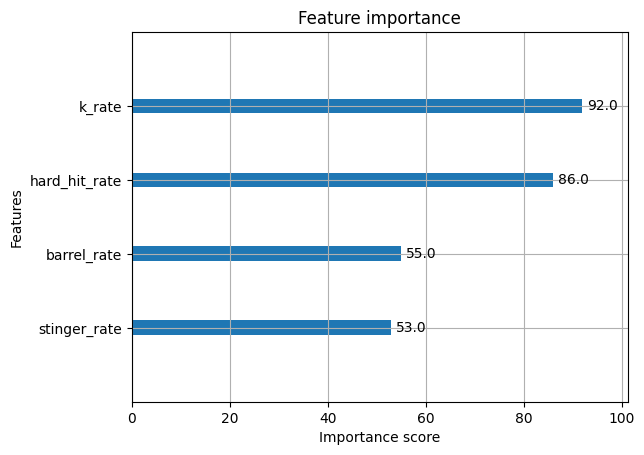

In [203]:
from xgboost import plot_importance

plot_importance(xgb)
plt.show()

In [9]:
# Creates subsets of the original dataset with all the stingers and gappers from 
# the original data

stingers, gappers = get_stingers(data)

In [678]:
stingers_per = stingers[['stinger','name']].groupby('name').count().reset_index()
gappers_per = gappers[['gapper','name']].groupby('name').count().reset_index()

In [14]:
gapper_counts = get_counts(gappers)
stinger_counts = get_counts(stingers)


gapper_stats = create_stats(gapper_counts)

stinger_stats = create_stats(stinger_counts)
print(gapper_stats)
print(stinger_counts)
print(stingers.shape)

{'BA': 0.7539606006336961, 'SLG': 1.059374569499931}
{'singles': 8705, 'doubles': 2773, 'triples': 173, 'home runs': 137, 'field outs': 3856, 'gidps': 96, 'force_outs': 67, 'dps': 115, 'fcs': 4, 'k': 0}
(16031, 12)


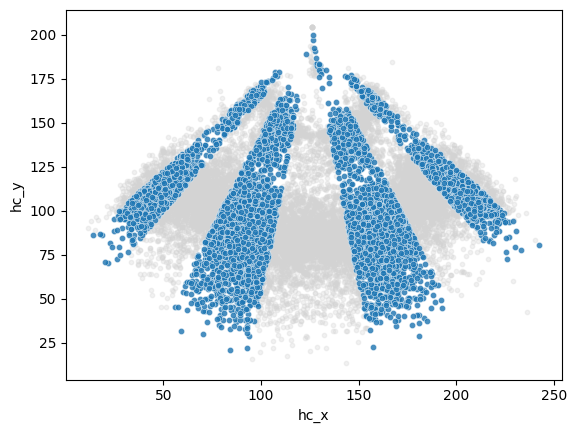

In [680]:
graph_gappers_stingers(gappers, stingers)

In [681]:
gapper_leaders = gappers.groupby('name').size().sort_values(ascending=False)[:100]
stinger_leaders = stingers.groupby('name').size().sort_values(ascending=False)
gapper_rate_leaders = gapper_leaders/stinger_leaders

print(gapper_leaders.head(20))
print(stinger_leaders.head(20))

print(stinger_counts)



name
Maikel Garcia         40
Francisco Lindor      40
Trevor Story          39
Geraldo Perdomo       38
Pete Alonso           38
Luis Arraez           38
Bobby Witt            38
Yandy Díaz            38
William Contreras     38
Taylor Ward           37
Julio Rodríguez       37
Bo Bichette           36
Andy Pages            35
Vinnie Pasquantino    34
Gunnar Henderson      34
Vladimir Guerrero     34
James Wood            33
Manny Machado         33
Dillon Dingler        33
Steven Kwan           33
dtype: int64
name
Francisco Lindor      84
Maikel Garcia         80
Bo Bichette           80
Luis Arraez           77
Pete Alonso           77
Yandy Díaz            77
Bobby Witt            76
Corbin Carroll        75
Manny Machado         75
William Contreras     73
Julio Rodríguez       72
Vinnie Pasquantino    72
José Ramírez          72
Vladimir Guerrero     71
James Wood            70
Matt Olson            70
Bryan Reynolds        70
Michael Harris        69
Steven Kwan           68
Ge

In [682]:
gappers.shape[0]/stingers.shape[0]

0.455670876578717

In [78]:
print(len(stingers[stingers['cluster']==1]))
print(stingers.shape)

10434
(15289, 10)


In [ ]:
stingers[stingers['cluster']

In [185]:
stinger_count.sort_values(ascending=False)
bbes.shape

(109517, 8)

### Looking for the optimal number of clusters for the scaled batted-ball-event data

In [30]:
# Printing silhouette scores and corresponding elbow plot for k-values between 2 and 11

k_range = range(2,12)
silhouette_and_elbow(bbes_scaled, k_range)

Seems like 3 clusters is the optimal number. 

### Analyzing clusters

In [20]:
km = KMeans(n_clusters=3, n_init=10, random_state=RANDOM_STATE).fit(bbes_scaled)
bbes['cluster'] = km.fit_predict(bbes_scaled)
bbes.shape

(109517, 9)

In [9]:
print(bbes[desc_cols].groupby('cluster').mean())
print(bbes[desc_cols].groupby('cluster').std())

         launch_angle  launch_speed
cluster                            
0            5.765292     97.826813
1            44.05182     83.348833
2          -20.421387     68.630987
         launch_angle  launch_speed
cluster                            
0           15.418103      6.800054
1           17.131574     10.252057
2           24.041212     13.262124


### Results
    - 3 clusters: 
        - Line drives (high launch_speed, low positive launch_angle)
        - Fly balls (medium launch_speed, high positive launch_angle)
        - Ground balls (low launch_speed, low launch_angle)
For our analysis we are looking for line drives that get down into the gaps. We should isolate cluster 0 to look for our gappers with the relative_spray angle included.



In [10]:
line_drives = bbes[(bbes['cluster']==0)].drop('cluster',axis=1,inplace=False)
line_drives_scaled = statcast_scale_bbes(line_drives[scaling_cols])
line_drives.head()

,name,launch_speed,launch_angle,batter,events,hc_x,hc_y,relative_spray
350,Dillon Dingler,85.9,10,693307,field_out,156.82,166.06,44.270444
778,Gabriel Arias,85.5,-6,672356,field_out,141.63,149.86,18.513028
671,Daniel Schneemann,105.3,5,682177,double,175.55,102.27,-27.573001
706,Steven Kwan,92.0,14,680757,double,198.59,132.55,-48.070379
1016,C.J. Kayfus,91.4,-2,692216,field_out,159.85,170.11,-50.720563


{'2': 0.3706042119339254, '3': 0.35588615287108516, '4': 0.35904090035391356, '5': 0.35269434628613555, '6': 0.3586215620900418}


{'2': 0.3706042119339254,
 '3': 0.35588615287108516,
 '4': 0.35904090035391356,
 '5': 0.35269434628613555,
 '6': 0.3586215620900418}

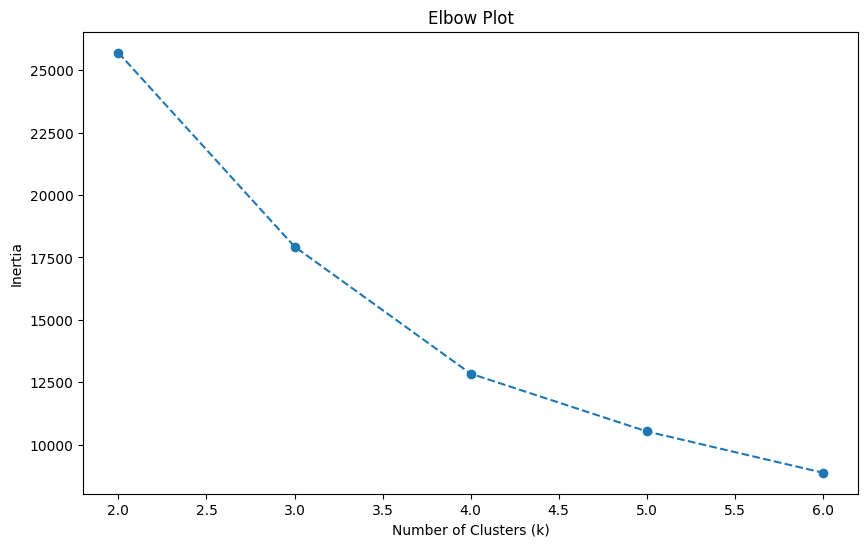

In [11]:
k_range = range(2,7)
silhouette_and_elbow(line_drives_scaled,k_range)

In [11]:
km4 = KMeans(n_clusters=4, n_init = 10, random_state = RANDOM_STATE).fit(line_drives_scaled)
line_drives['cluster'] = km4.fit_predict(line_drives_scaled)
print(line_drives[desc_cols].groupby('cluster').mean())
print(line_drives[desc_cols].groupby('cluster').std())


         launch_angle  launch_speed
cluster                            
0           22.839212     98.732584
1          -14.954041     95.968836
2            5.306973    104.707532
3            5.777417     89.120462
         launch_angle  launch_speed
cluster                            
0            7.654087      3.457514
1            8.844987      4.445033
2            8.136599      3.627221
3            8.315264      3.826976


### Results of reclustering 
    - Cluster 0 - Represents line drives hit down
    - Cluster 1 - Essentially barrels, hard hit balls hit in the air. 
    - Cluster 2 - Line drives hit up
    - Cluster 3 - Line drives hit up
This means that clusters 2 and 3 should contain the gappers. Cluster 1 is hit too high in the air and is essentially just the natural cluster for barrels, which are irrelevant to our analysis.

<Axes: xlabel='hc_x', ylabel='hc_y'>

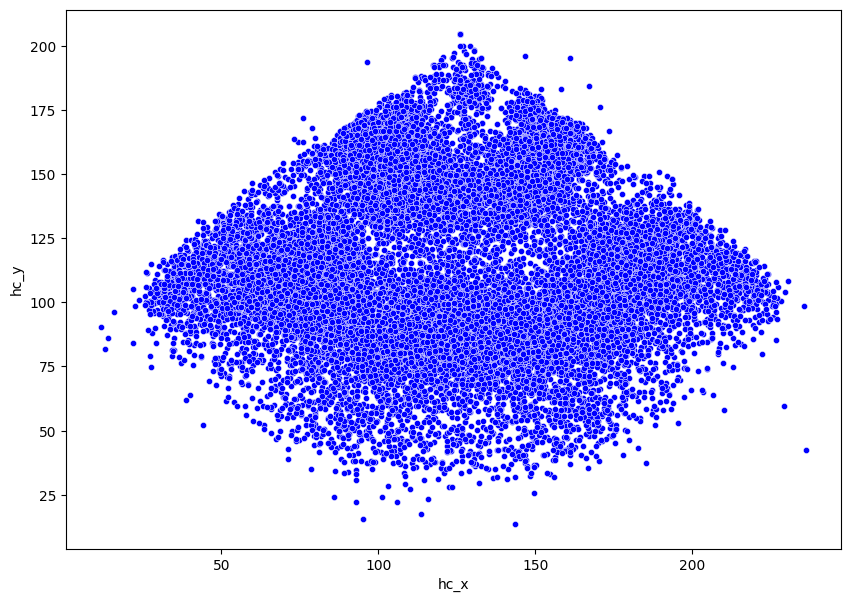

In [13]:
plt.figure(figsize=(10,7))

sns.scatterplot(data = pot_gappers,
                x = 'hc_x',
                y = 'hc_y',
                color = 'blue',
                s=20
               )

<Axes: xlabel='hc_x', ylabel='hc_y'>

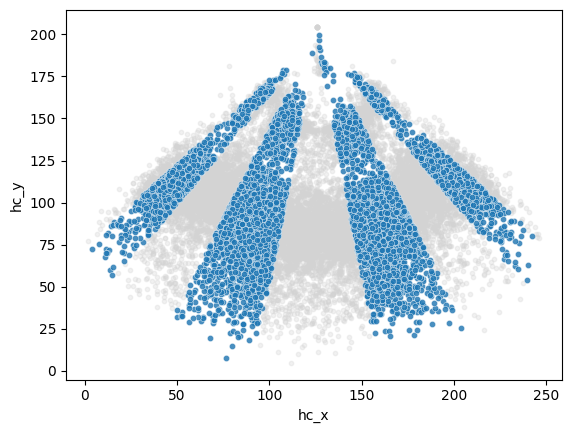

In [130]:
plt.scatter(stingers['hc_x'], stingers['hc_y'],
            color = 'lightgrey', s = 10, alpha = 0.3)
sns.scatterplot(data = gappers,
                x = 'hc_x',
                y = 'hc_y',
                s = 20,
                alpha = 0.8
               )